# 1) USBP Monthly Encounters: Ingestion, Cleaning, and Graphing

### 📌 Note on Graphics
This notebook uses Plotly for its visualizations — I chose it for its ease of use and interactivity. However, GitHub doesn’t support the JavaScript required to render Plotly charts. To improve static rendering, I set:

In [1]:
import plotly.io as pio
pio.renderers.default = "vscode+png"

This generates PNG snapshots alongside the interactive charts. That said, I’ve noticed that scales and annotations sometimes render incorrectly in these static images. If the graphics are important to you, I recommend cloning the repo and running the notebook locally for the full experience.

---

This notebook focuses on the "Monthly Region" sheet from the "CBP Encounters - USBP - November 2024" file taken from the Office of Homeland Security Statistics (OHSS)'s [CBP Encounters](https://ohss.dhs.gov/khsm/cbp-encounters) page on September 30, 2025. The file covers US Border Patrol (USBP) encounters from October of Fiscal year 2000 through November of Fiscal Year 2025.

While a corresponding file exists for the Office of Field Opeations (OFO), I've chosen not to include it here. My interest is in immigration enforcement, and the OFO data blends administrative and enforcement activity - with much smaller enforcement numbers overall. For clarity and focus, I've limited the scope to USBP.

Dates in this file use a fiscal year. The federal fiscal year runs October 1 through September 30. This means that October 1, 2024 (which is in this dataset) appears as year `Fiscal Year 2025` and month `01 October` (i.e. the first month of FY2025).

This workbook shows how to ingest the "Monthly Region" sheet from the Excel file, clean, and graph it in Python. It also shows how to get the same result by calling the function `get_monthly_region_df` from the new `encounters` module.

In [2]:
import pandas as pd
from datetime import datetime
import plotly.express as px

# Read in data and rename columns for convenience.
df = pd.read_excel("KHSM Encounters (USBP) fy25m11.xlsx", sheet_name="Monthly Region")
df = df.rename(columns={"Fiscal\nYear": "Fiscal_Year"})
df.columns = df.columns.str.lower()
df.head()

,fiscal_year,month,region,quantity
0,2000,01 October,Coastal Border,740
1,2000,01 October,Northern Land Border,1250
2,2000,01 October,Southwest Land Border,87820
3,2000,02 November,Coastal Border,500
4,2000,02 November,Northern Land Border,960


In [3]:
# Create a FiscalDate column that is a datetime object that is a combination of the FiscalYear and Month columns.
df.month = df.month.str.split().str[1]  # Convert "01 October" to just "October"
df["fiscal_date"] = df.fiscal_year.astype(str) + " " + df.month
df.fiscal_date = pd.to_datetime(df.fiscal_date, format="%Y %B")  # Day defaults to 1

df.head()

,fiscal_year,month,region,quantity,fiscal_date
0,2000,October,Coastal Border,740,2000-10-01
1,2000,October,Northern Land Border,1250,2000-10-01
2,2000,October,Southwest Land Border,87820,2000-10-01
3,2000,November,Coastal Border,500,2000-11-01
4,2000,November,Northern Land Border,960,2000-11-01


In [4]:
# Create a Date column that is the calendar date. This means that months >= October
# need to have 1 subtracted from the year
def convert_fiscal_date_to_calendar_date(fiscal_date):
    if fiscal_date.month >= 10:
        return datetime(fiscal_date.year - 1, fiscal_date.month, fiscal_date.day)
    else:
        return fiscal_date


df["date"] = df.fiscal_date.apply(convert_fiscal_date_to_calendar_date)
df.head()

,fiscal_year,month,region,quantity,fiscal_date,date
0,2000,October,Coastal Border,740,2000-10-01,1999-10-01
1,2000,October,Northern Land Border,1250,2000-10-01,1999-10-01
2,2000,October,Southwest Land Border,87820,2000-10-01,1999-10-01
3,2000,November,Coastal Border,500,2000-11-01,1999-11-01
4,2000,November,Northern Land Border,960,2000-11-01,1999-11-01


In [5]:
# Now subset columns
df = df[["date", "region", "quantity"]]
df.head()

,date,region,quantity
0,1999-10-01,Coastal Border,740
1,1999-10-01,Northern Land Border,1250
2,1999-10-01,Southwest Land Border,87820
3,1999-11-01,Coastal Border,500
4,1999-11-01,Northern Land Border,960


## Graphing and Analysis

Now that the data is using standard dates, we can graph it with Plotly like this:

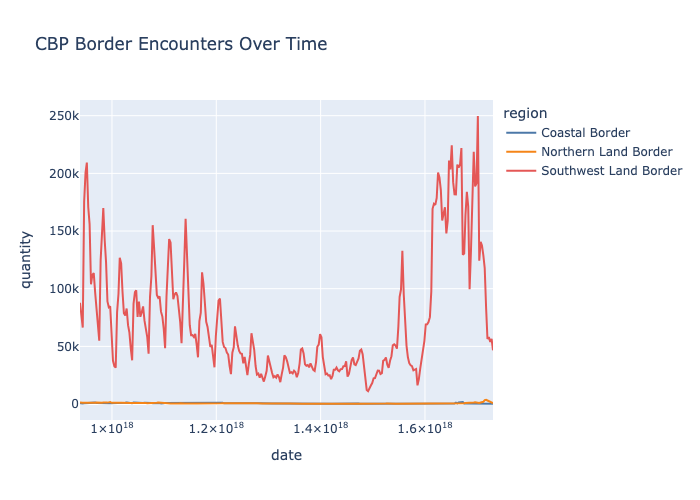

In [6]:
px.line(
    df,
    x="date",
    y="quantity",
    color="region",
    title="CBP Border Encounters Over Time",
    color_discrete_sequence=px.colors.qualitative.T10,
)

Some takeaways from the graph:
  * Nearly all USBP immigration enforcement activity occurred along the Southwest Land Border.
  * Until around 2015, encounters followed a strong seasonal pattern, typically dipping in December and peaking in March.
  * May 2019 saw an unprecedented spike in encounters.
  * The surge from 2020 to 2021 was similarly without precedent, marking a sharp departure from prior trends.

## `encounters` Module

To make it easier for others (and myself) to work with this data, I have wrapped the above code in the function `get_monthly_region_df` in the `encounters` module in this directory. Note that it takes an optional `output_format` parameter, so you can get the data in long or wide format. It defaults to `long`.

In [7]:
from encounters import get_monthly_region_df

df2 = get_monthly_region_df()
df2.head()

,date,region,quantity
0,1999-10-01,Coastal Border,740
1,1999-10-01,Northern Land Border,1250
2,1999-10-01,Southwest Land Border,87820
3,1999-11-01,Coastal Border,500
4,1999-11-01,Northern Land Border,960


In [8]:
df.equals(df2)

True

In [9]:
get_monthly_region_df(output_format="wide")

,date,Coastal Border,Northern Land Border,Southwest Land Border
0,1999-10-01,740,1250,87820
1,1999-11-01,500,960,74360
2,1999-12-01,530,1010,66260
3,2000-01-01,690,1140,175380
4,2000-02-01,780,1080,200620
...,...,...,...,...
297,2024-07-01,220,3040,56400
298,2024-08-01,240,2430,58010
299,2024-09-01,340,1790,53860
300,2024-10-01,320,1280,56530
